In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import missingno as msno
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from statsmodels.stats import diagnostic
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestRegressor

plt.style.use('ggplot')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/car_prices/car_prices.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [ ]:
data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [ ]:
print(data.isnull().sum())

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64


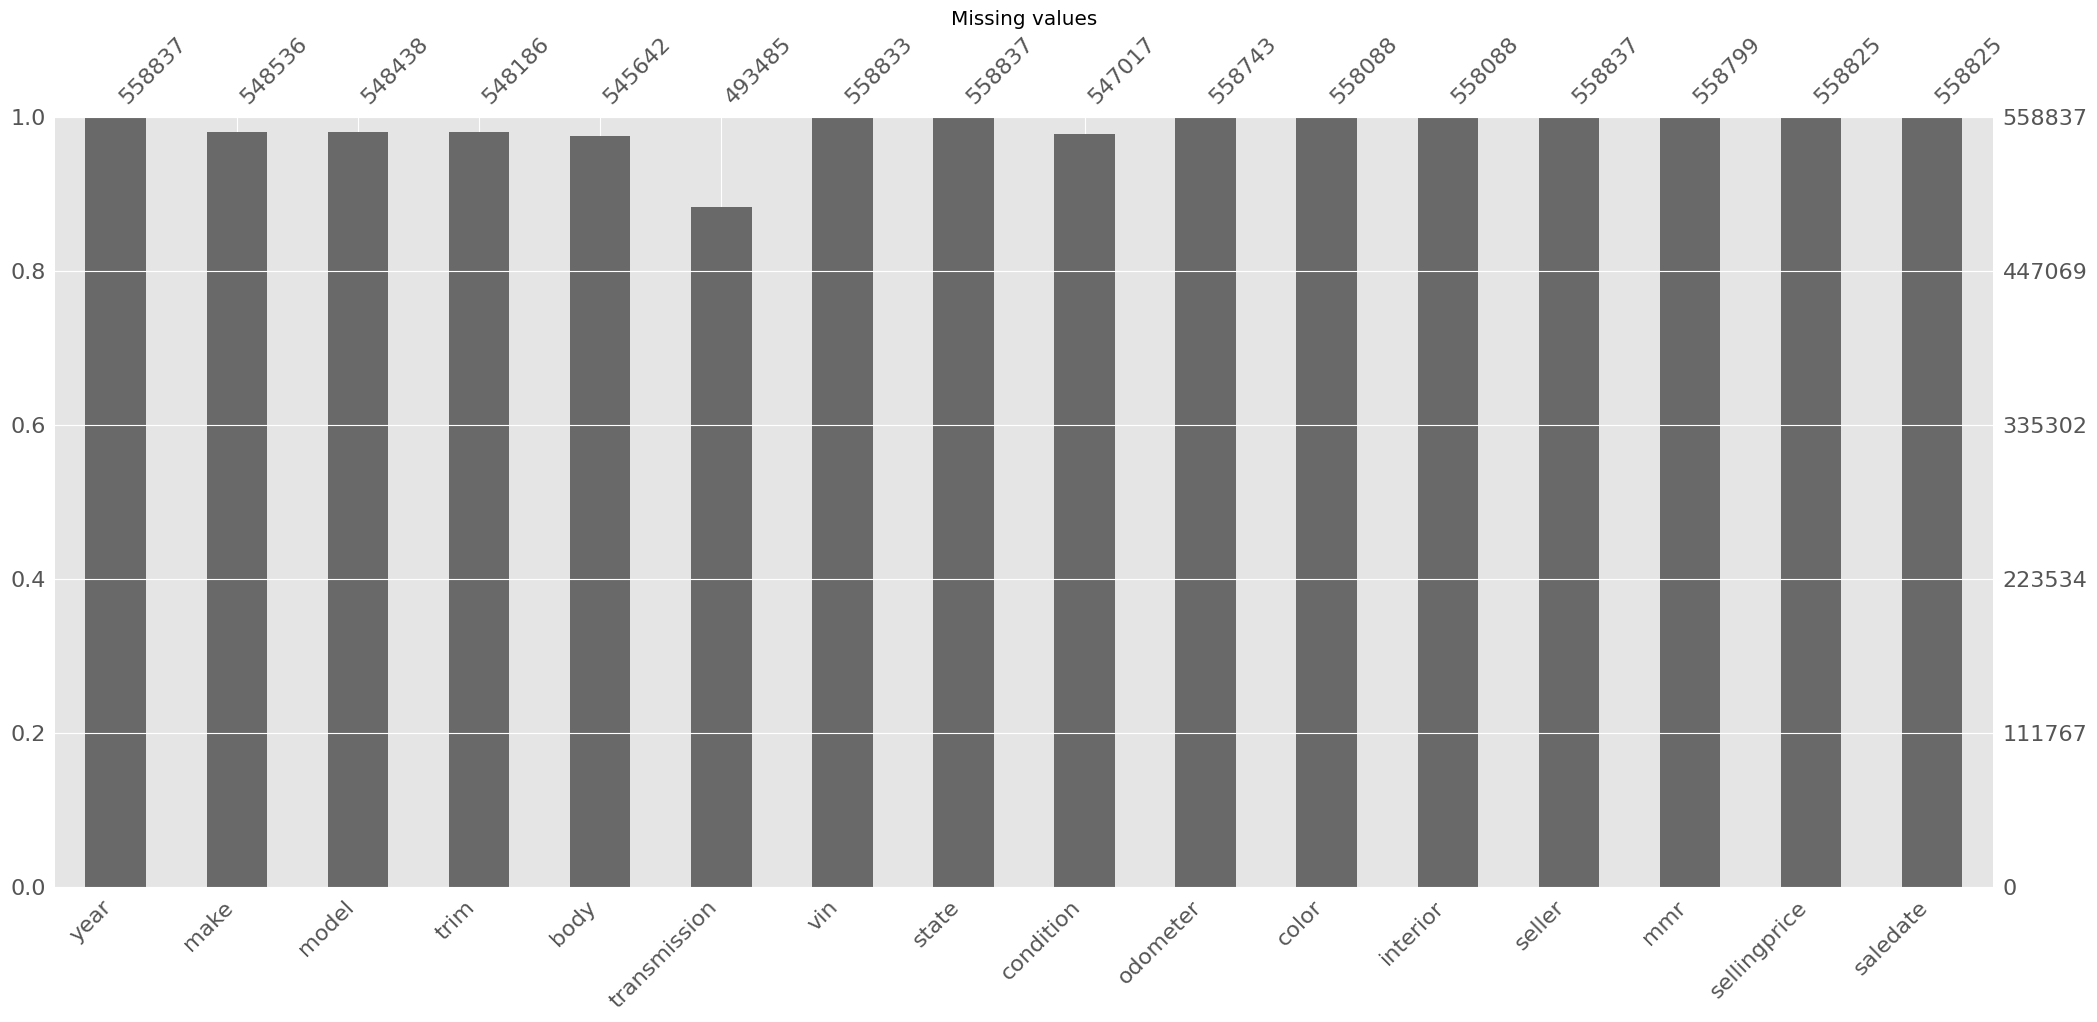

In [ ]:
msno.bar(data)
plt.title('Missing values')
plt.show()

In [ ]:
data.loc[:,'make'] = data.loc[:,['make']].fillna(data['make'].mode()[0])
data.loc[:,'model'] = data.loc[:,['model']].fillna(data['model'].mode()[0])
data.loc[:,'body'] = data.loc[:,['body']].fillna(data['body'].mode()[0])
data.loc[:,'trim'] = data.loc[:,['trim']].fillna(data['trim'].mode()[0])
data.loc[:,'color'] = data.loc[:,['color']].fillna(data['color'].mode()[0])
data.loc[:,'interior'] = data.loc[:,['interior']].fillna(data['interior'].mode()[0])
data.loc[:,'transmission'] = data.loc[:,['transmission']].fillna(data['transmission'].mode()[0])

data.loc[:,'condition'] = data.loc[:,['condition']].fillna(data['condition'].mean())
data.loc[:,'odometer'] = data.loc[:,['odometer']].fillna(data['odometer'].mean())
data.loc[:,'mmr'] = data.loc[:,['mmr']].fillna(data['mmr'].mean())

data.dropna(subset=['sellingprice'],axis='rows',inplace=True)

In [ ]:
print(data.isnull().sum())

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             4
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64


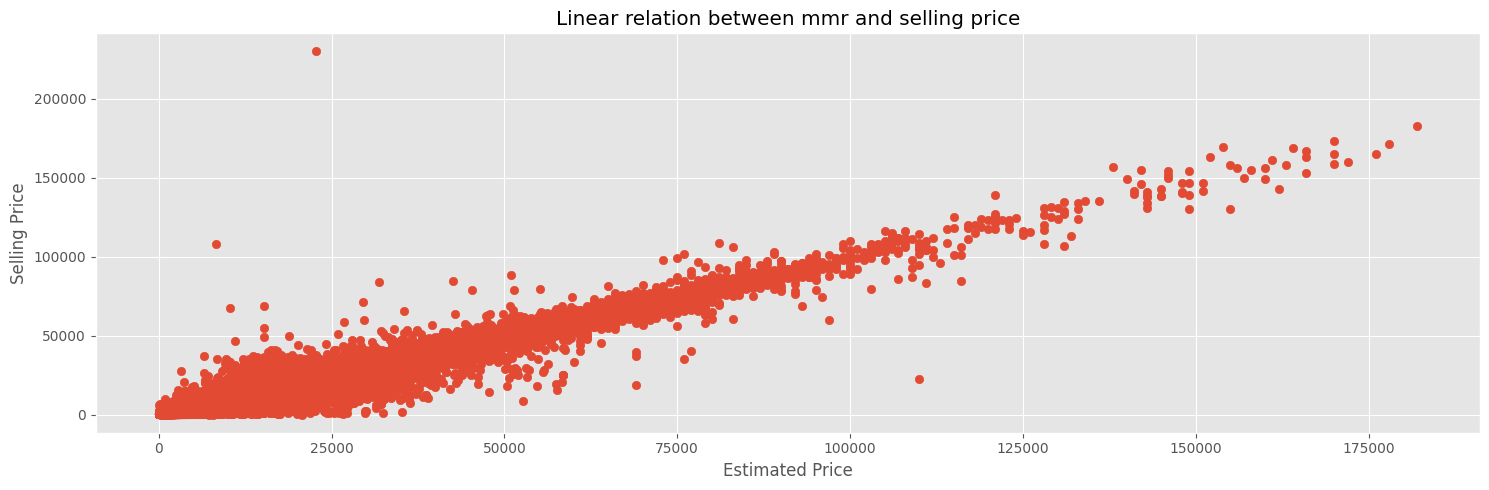

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(data['mmr'],data['sellingprice'])
plt.xlabel("Estimated Price")
plt.ylabel('Selling Price')
plt.title("Linear relation between mmr and selling price")
plt.tight_layout()
plt.show()

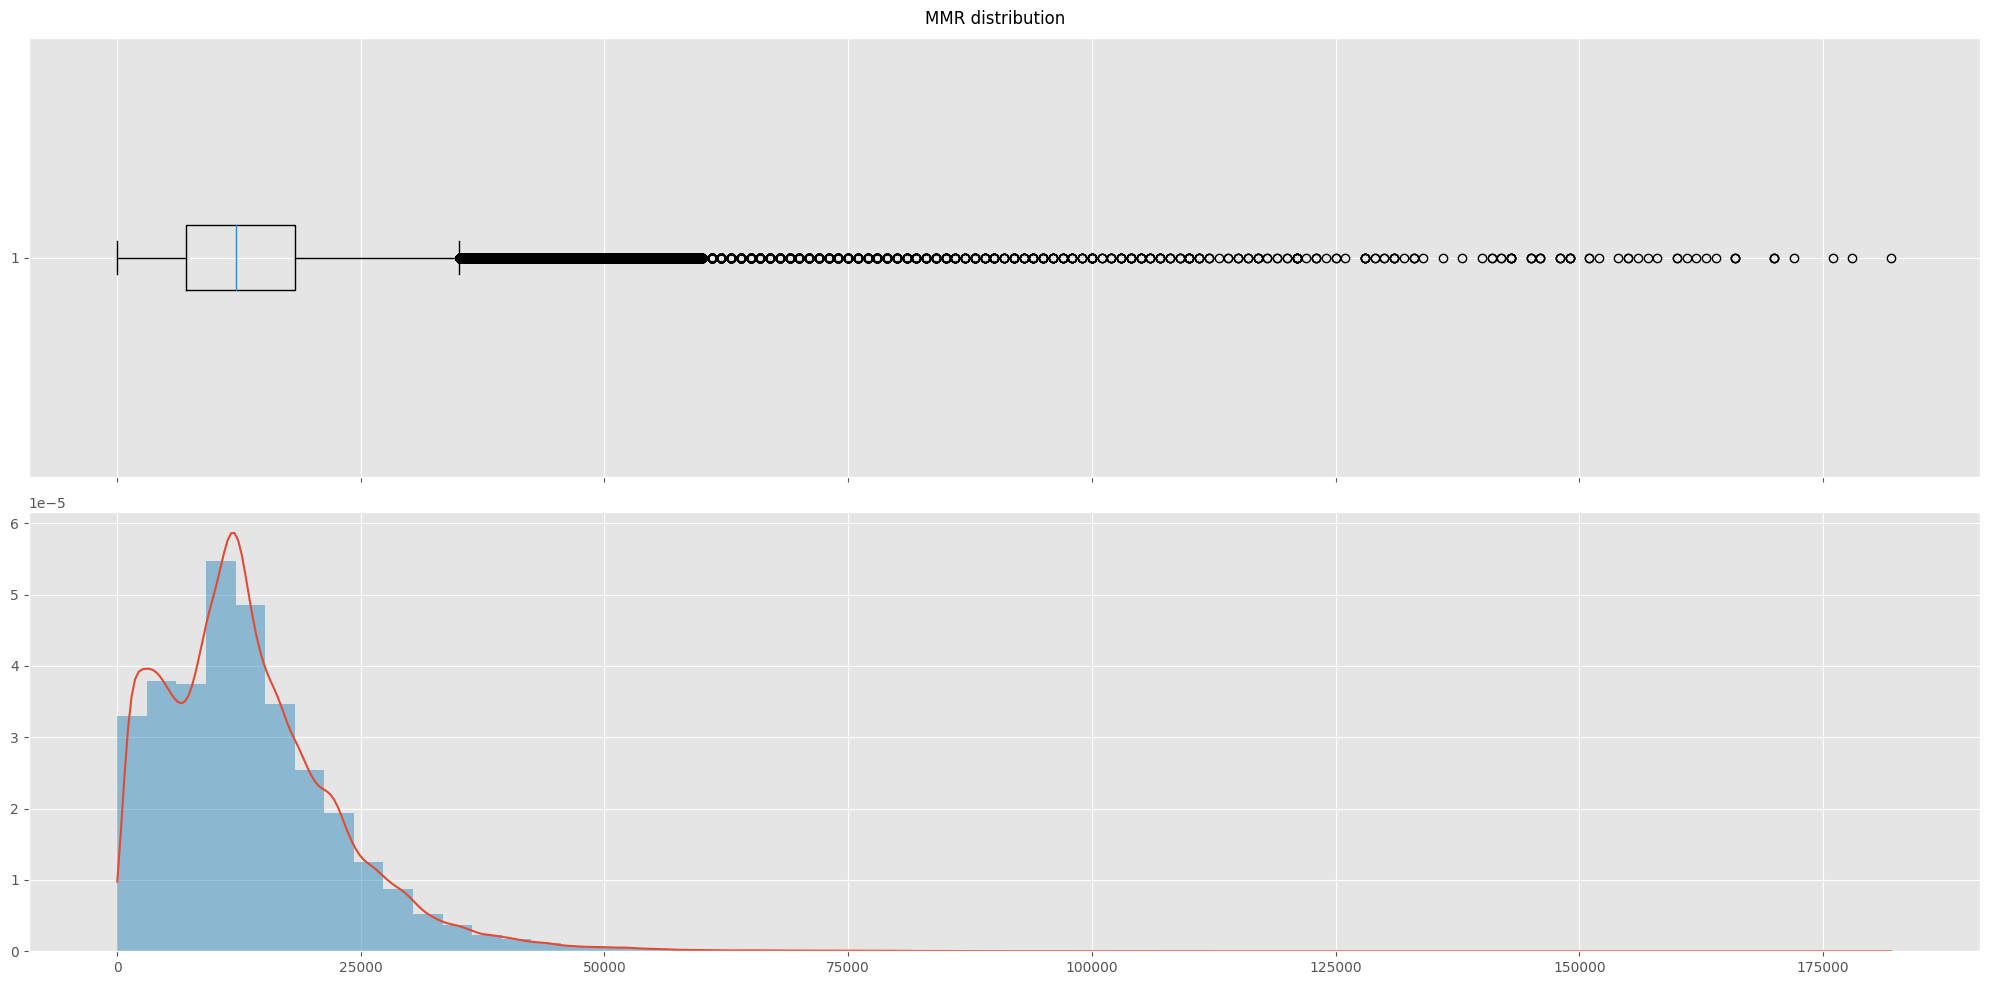

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

kde = gaussian_kde(data['mmr'])
kde_x = np.linspace(data['mmr'].min(), data['mmr'].max(), 500)

ax[0].boxplot(data['mmr'],vert=False)

kde_y = kde(kde_x)

ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data['mmr'],bins=60,alpha=0.5,density=True)

plt.suptitle('MMR distribution')
plt.tight_layout()
plt.show()

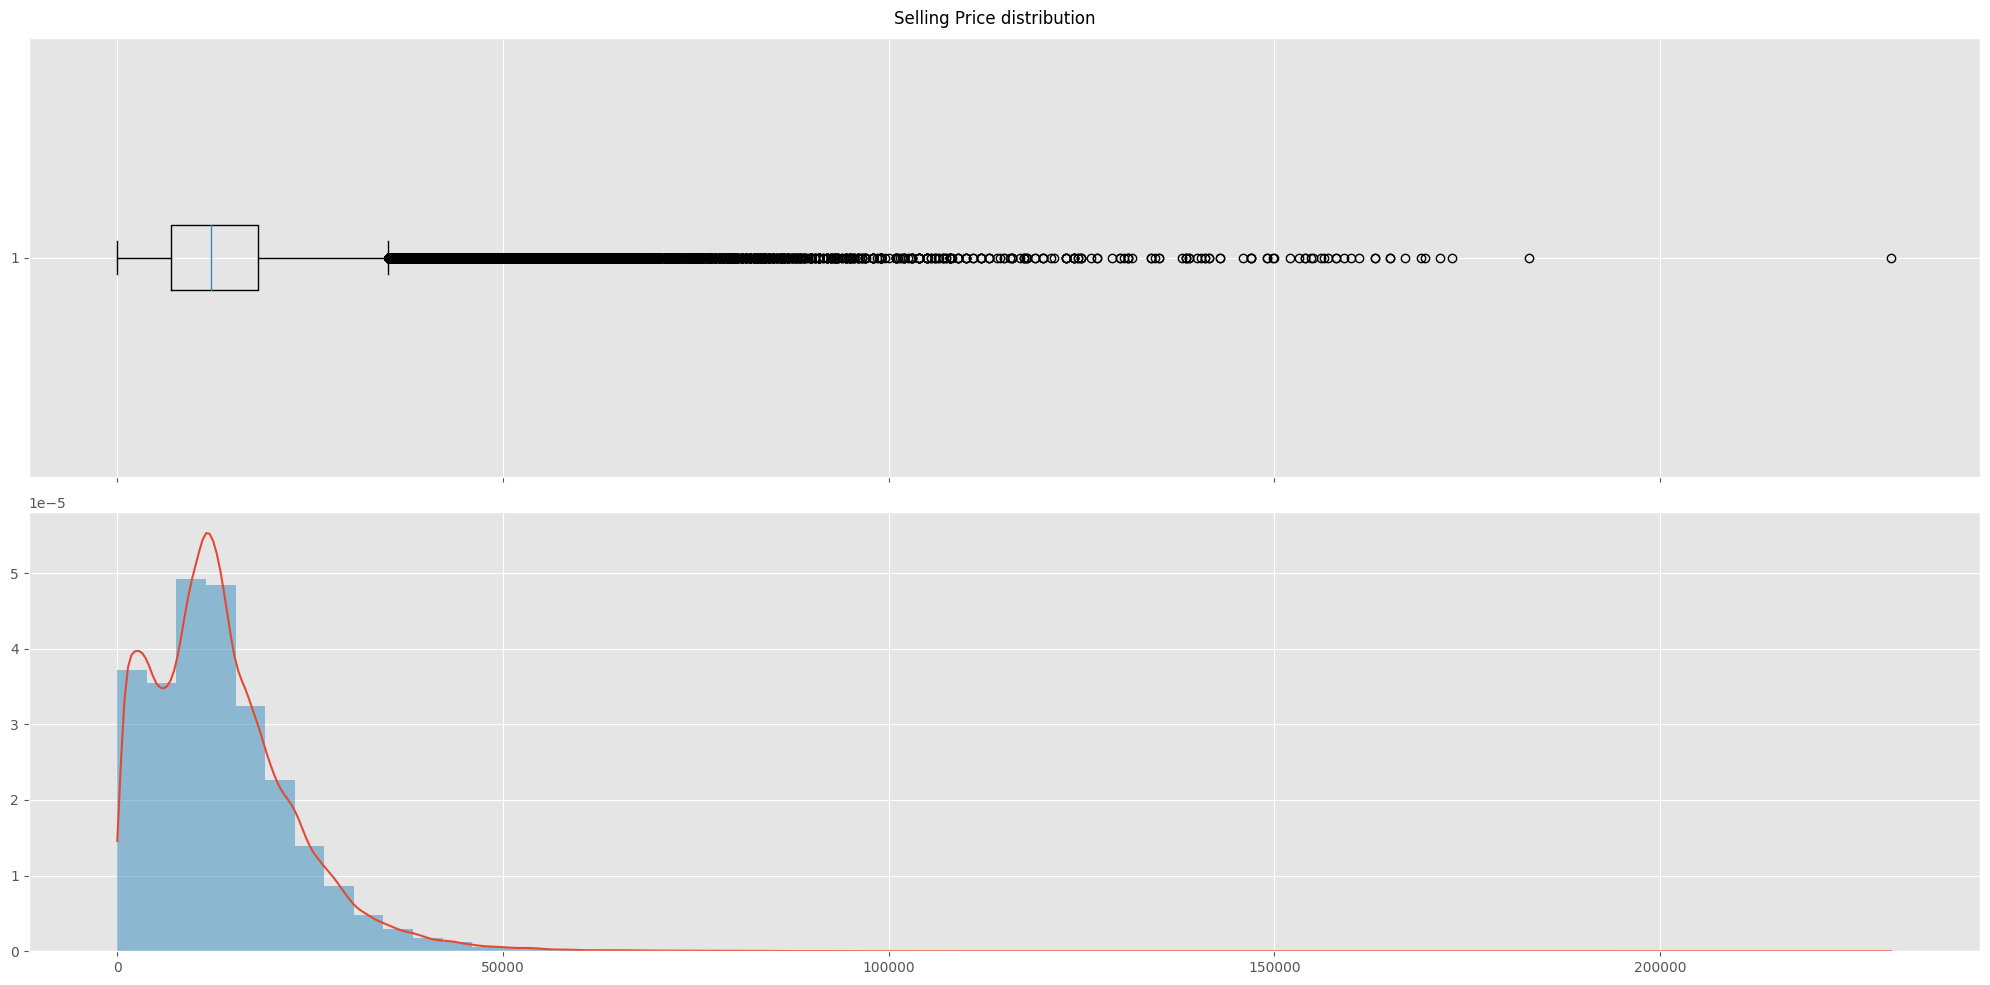

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

kde = gaussian_kde(data['sellingprice'])
kde_x = np.linspace(data['sellingprice'].min(), data['sellingprice'].max(), 500)

ax[0].boxplot(data['sellingprice'],vert=False)

kde_y = kde(kde_x)

ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data['sellingprice'],bins=60,alpha=0.5,density=True)

plt.suptitle('Selling Price distribution')
plt.tight_layout()
plt.show()

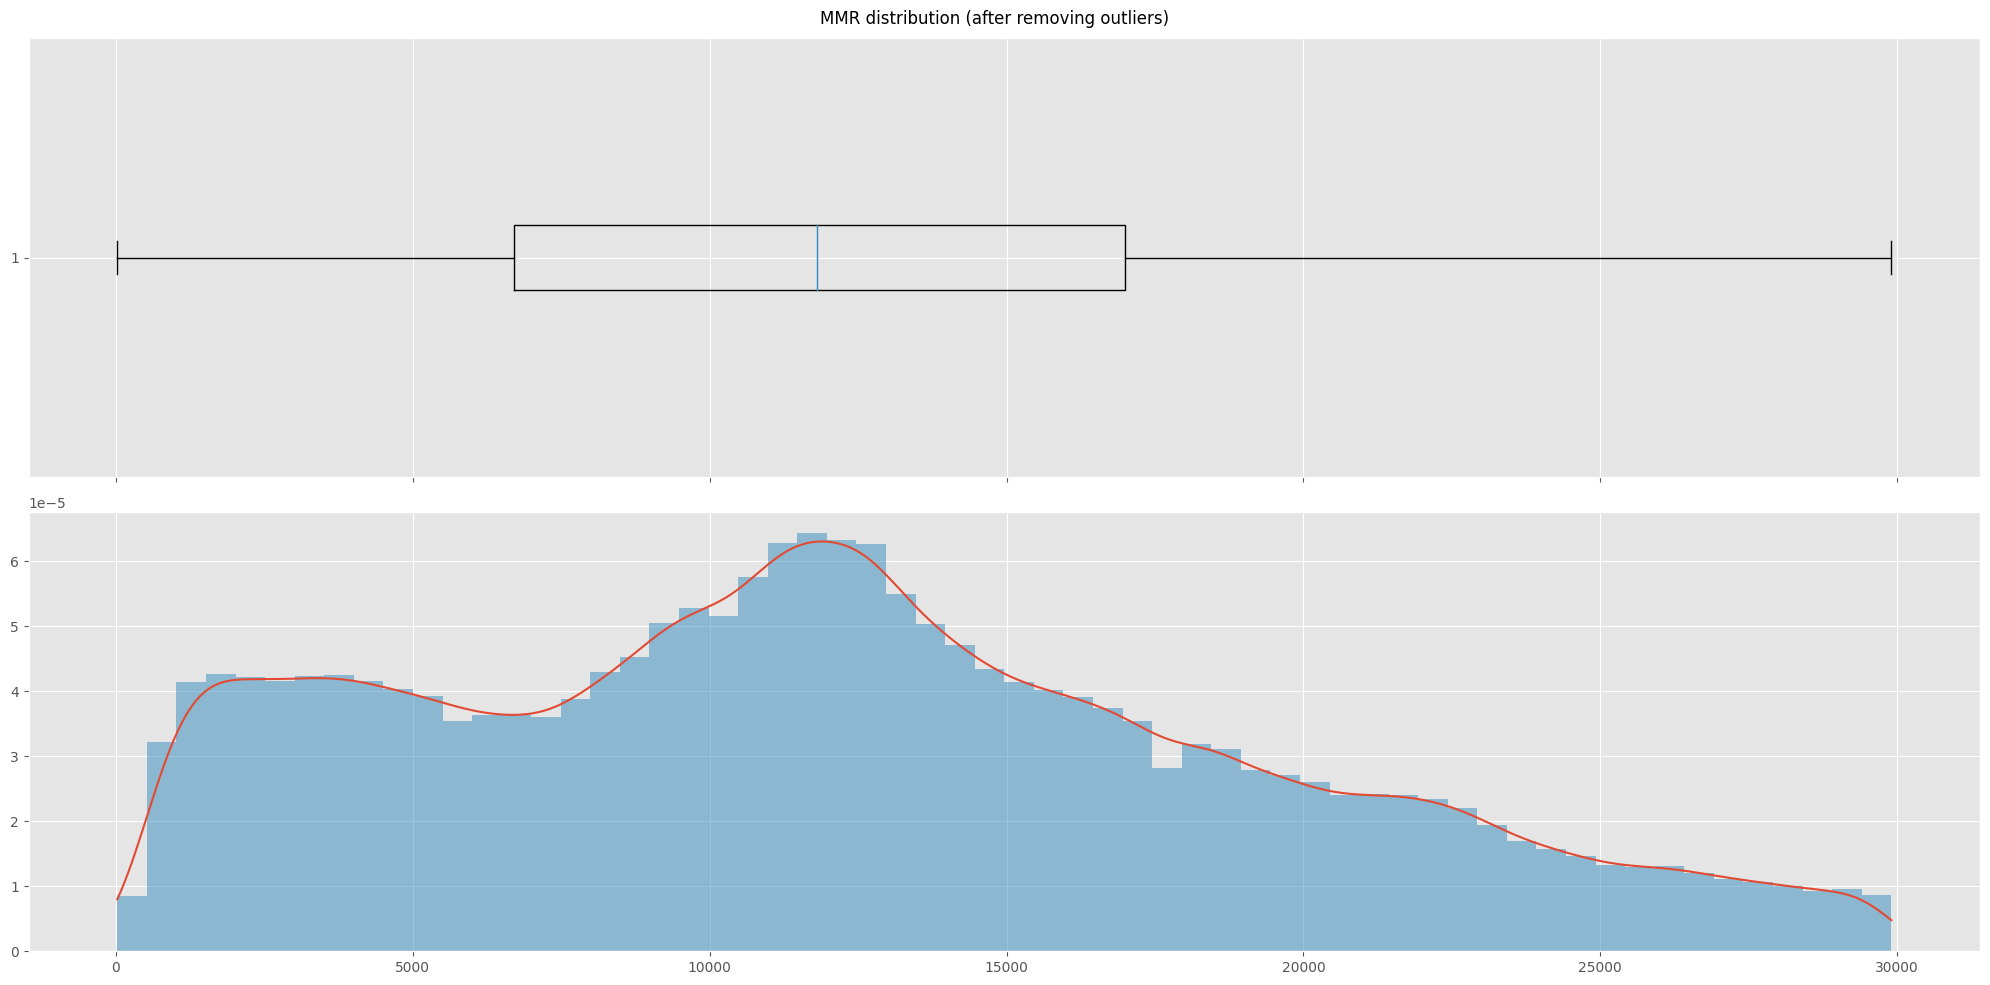

In [ ]:
data1 = data.loc[data['mmr'] < 30000,:]

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

kde = gaussian_kde(data1['mmr'])
kde_x = np.linspace(data1['mmr'].min(), data1['mmr'].max(), 500)

ax[0].boxplot(data1['mmr'],vert=False)

kde_y = kde(kde_x)

ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data1['mmr'],bins=60,alpha=0.5,density=True)

plt.suptitle('MMR distribution (after removing outliers)')
plt.tight_layout()
plt.show()

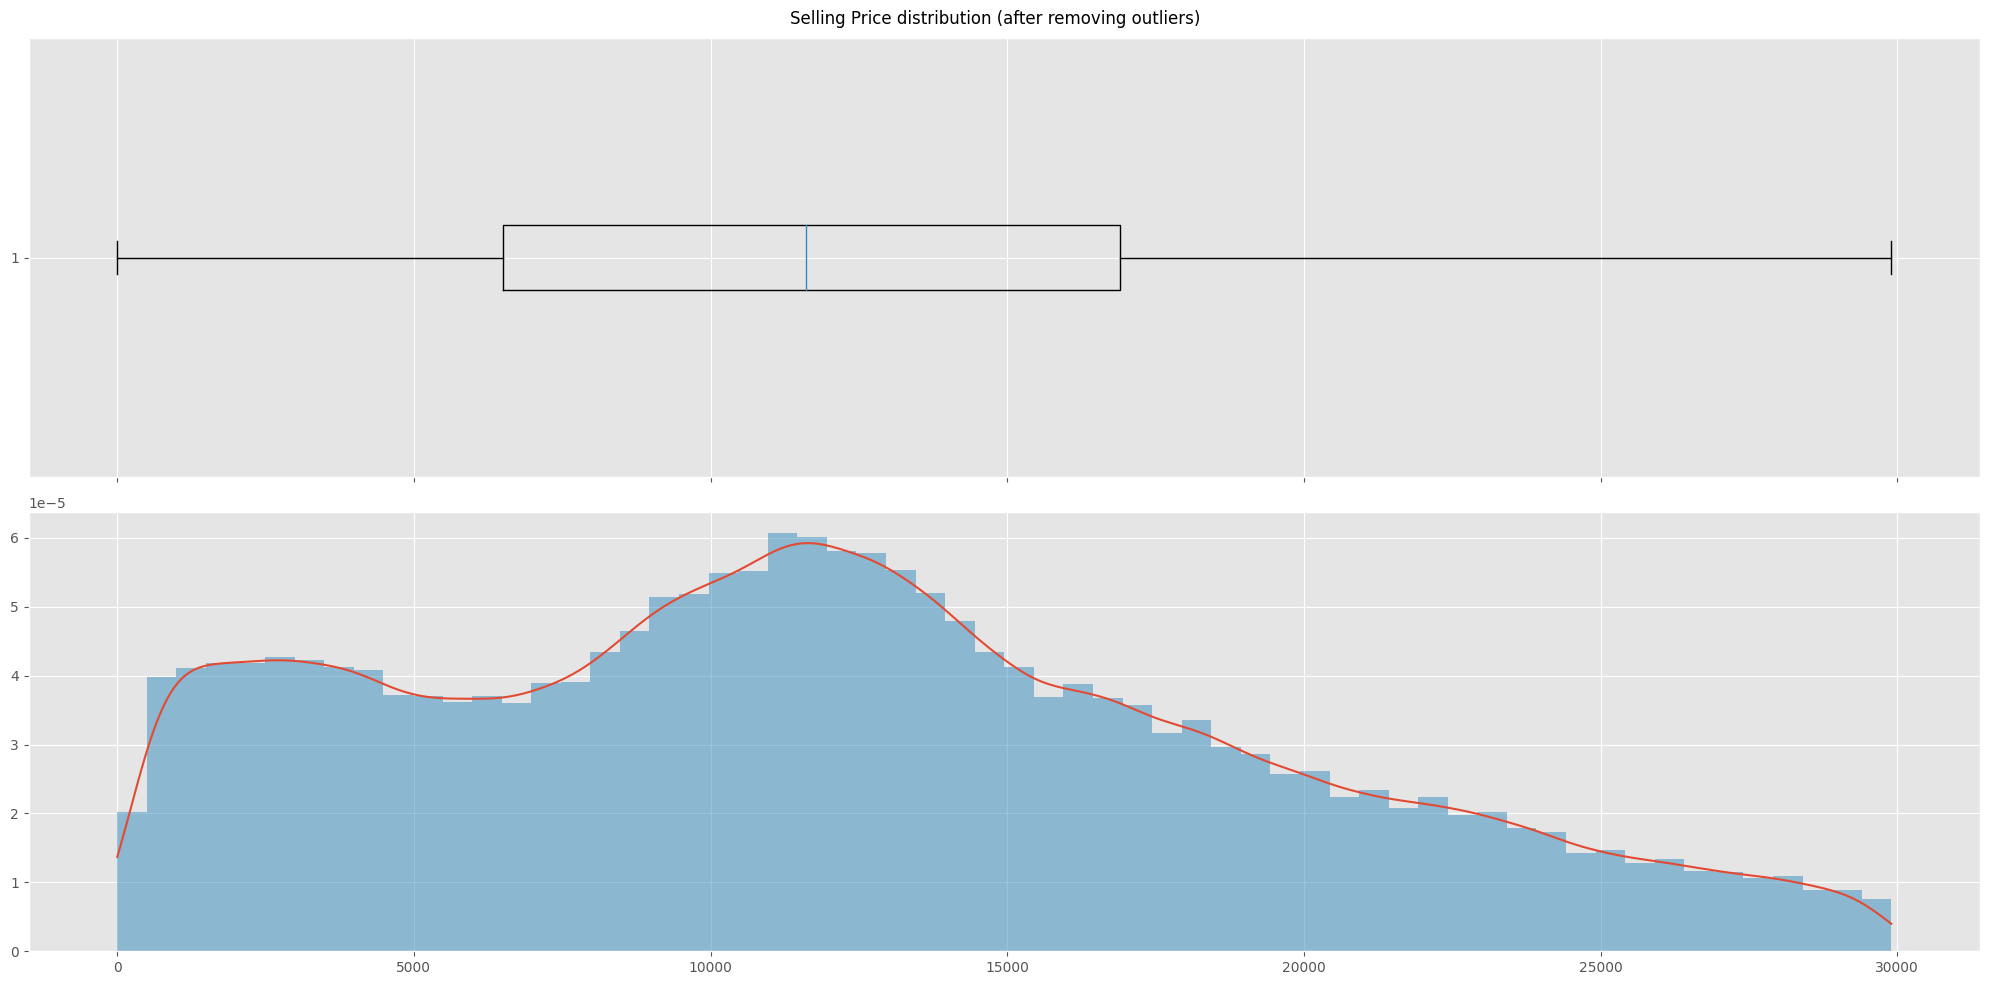

In [ ]:
data1 = data.loc[data['sellingprice'] < 30000,:]

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,10),sharex=True)

kde = gaussian_kde(data1['sellingprice'])
kde_x = np.linspace(data1['sellingprice'].min(), data1['sellingprice'].max(), 500)

ax[0].boxplot(data1['sellingprice'],vert=False)

kde_y = kde(kde_x)

ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data1['sellingprice'],bins=60,alpha=0.5,density=True)

plt.suptitle('Selling Price distribution (after removing outliers)')
plt.tight_layout()
plt.show()

In [ ]:
data = data1.sample(frac=0.5,random_state=1,ignore_index=True)
data.drop(['seller','vin','saledate'],axis=1,inplace=True)
print(data.shape)
data.head()

(264040, 13)


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice
0,2000,Mercedes-Benz,S-Class,S430,Sedan,automatic,az,1.0,180536.0,black,black,1675.0,900.0
1,2012,Chrysler,200,Touring,Sedan,automatic,il,19.0,43541.0,blue,black,9475.0,8600.0
2,2009,Nissan,Versa,1.8 S,Hatchback,automatic,fl,3.0,85534.0,red,black,4450.0,4600.0
3,2013,Chevrolet,Impala,LT Fleet,Sedan,automatic,fl,38.0,52947.0,white,black,9300.0,9800.0
4,2014,Volkswagen,Tiguan,S,suv,automatic,fl,49.0,24415.0,blue,black,15300.0,15100.0


In [ ]:
categorical_cols = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'transmission']
for col in categorical_cols:
    print(f"{col}: {data[col].nunique()}")

make: 84
model: 852
trim: 1637
body: 76
state: 49
color: 31
interior: 17
transmission: 4


In [ ]:
for col in categorical_cols:
    counts = data[col].value_counts()
    other_categories = counts[counts <= 10].index.tolist()
    data[col] = data[col].apply(lambda x: 'Other' if x in other_categories else x)

In [ ]:
categorical_cols = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'transmission']
for col in categorical_cols:
    print(f"{col}: {data[col].nunique()}")

make: 69
model: 585
trim: 750
body: 62
state: 38
color: 20
interior: 17
transmission: 3


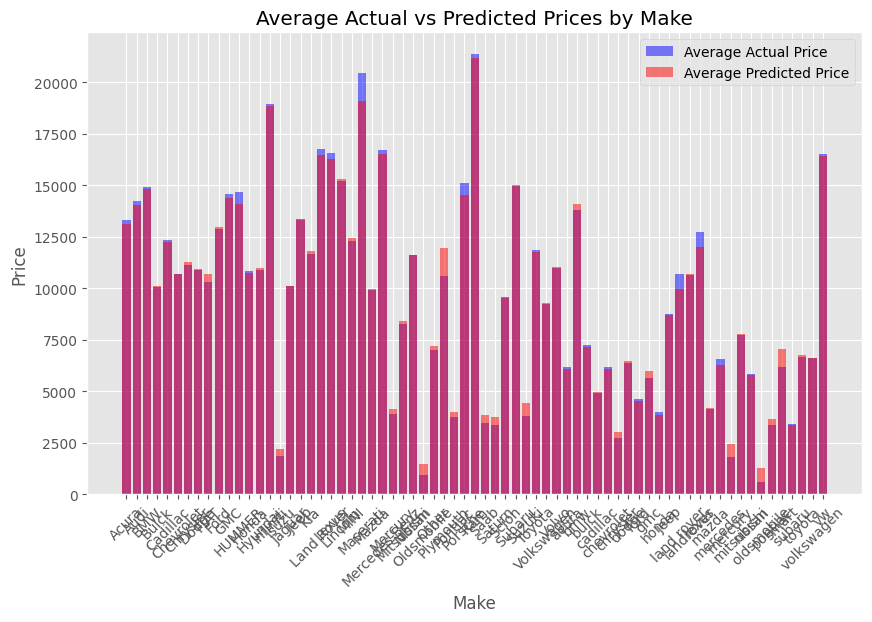

In [ ]:
# Group the dataset by 'make' and calculate the average selling price for each make
average_actual_prices = data.groupby('make')['sellingprice'].mean()

# Predict selling price for each data point using the trained model
predicted_prices = model.predict(X)

# Create a new DataFrame with actual and predicted prices
comparison_df = pd.DataFrame({'Actual Price': y, 'Predicted Price': predicted_prices})

# Group the predicted prices by 'make' and calculate the average predicted price for each make
average_predicted_prices = comparison_df.groupby(data['make'])['Predicted Price'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(average_actual_prices.index, average_actual_prices, color='blue', alpha=0.5, label='Average Actual Price')
plt.bar(average_predicted_prices.index, average_predicted_prices, color='red', alpha=0.5, label='Average Predicted Price')
plt.title('Average Actual vs Predicted Prices by Make')
plt.xlabel('Make')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
data['cars_age'] = data['year'].apply(lambda x : 2015 - x)

data = pd.get_dummies(data=data,columns=['transmission'],drop_first=True,dtype=int)

encoder = ce.binary.BinaryEncoder(cols=['make','body','interior','color','state'],drop_invariant=True).fit(data)
data = encoder.transform(data)

hasher = FeatureHasher(n_features=40, input_type='string')
hashed_features = hasher.transform(data[['model','trim']].astype(str).to_numpy())
hashed_features_df = pd.DataFrame(hashed_features.toarray())
hashed_features_df.columns = ['hashed_feature_' + str(i) for i in range(hashed_features_df.shape[1])]

data.drop(['year','model', 'trim'],axis=1,inplace=True)
data = pd.concat([data,hashed_features_df],axis=1)

data.head()

,make_0,make_1,make_2,make_3,make_4,make_5,make_6,body_0,body_1,body_2,...,hashed_feature_30,hashed_feature_31,hashed_feature_32,hashed_feature_33,hashed_feature_34,hashed_feature_35,hashed_feature_36,hashed_feature_37,hashed_feature_38,hashed_feature_39
0,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,0,0,0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


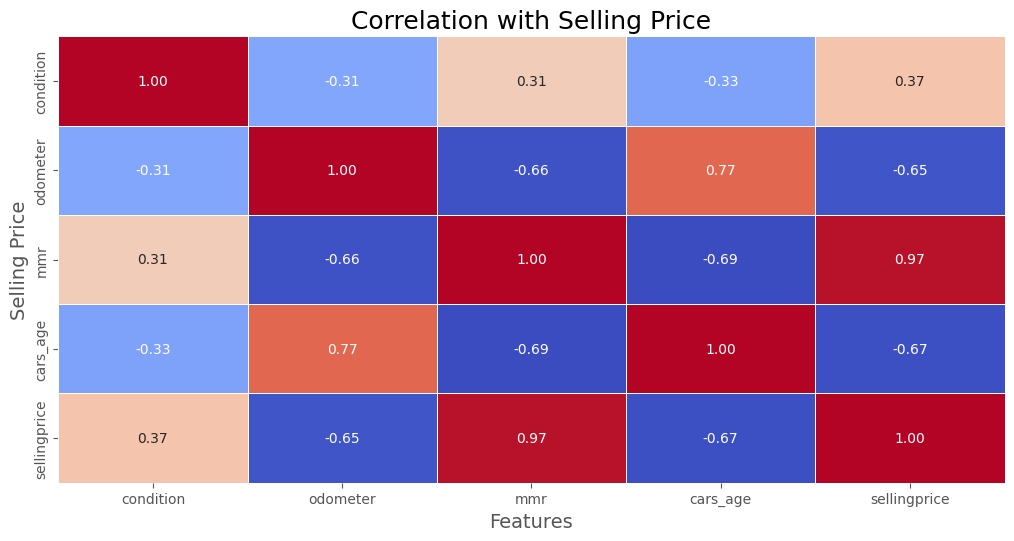

In [ ]:
plt.figure(figsize=(10, 5))
numeric_cols = ['condition','odometer','mmr','cars_age','sellingprice']

sns.heatmap(data[numeric_cols].corr(),
            cmap='coolwarm',
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cbar = False,
            )

plt.tight_layout()
plt.title('Correlation with Selling Price', fontsize=18)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Selling Price', fontsize=14)
plt.show()

In [ ]:
X = data.drop(['sellingprice'],axis=1)
y = data['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth = 16,
    max_features=0.3,
    bootstrap=True,
    max_samples=0.5,
    ccp_alpha = 1000,
    n_jobs=-1
)

In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=1000, max_depth=16, max_features=0.3,
                      max_samples=0.5, n_jobs=-1, random_state=42)

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [ ]:
final_mse_train = mean_squared_error(y_train, train_pred)
final_mse_test = mean_squared_error(y_test, test_pred)

print(f'Final RMSE on the train set: {np.sqrt(final_mse_train)}')
print(f'Final RMSE on the test set: {np.sqrt(final_mse_test)}')

Final RMSE on the train set: 1325.0964043115123
Final RMSE on the test set: 1354.055299290067


In [ ]:
# Calculate R2 score for training data
r2_train = r2_score(y_train, train_pred)

# Calculate R2 score for test data
r2_test = r2_score(y_test, test_pred)

print("R-squared score for training data:", r2_train)
print("R-squared score for test data:", r2_test)

R-squared score for training data: 0.9657066316770777
R-squared score for test data: 0.964261279029531


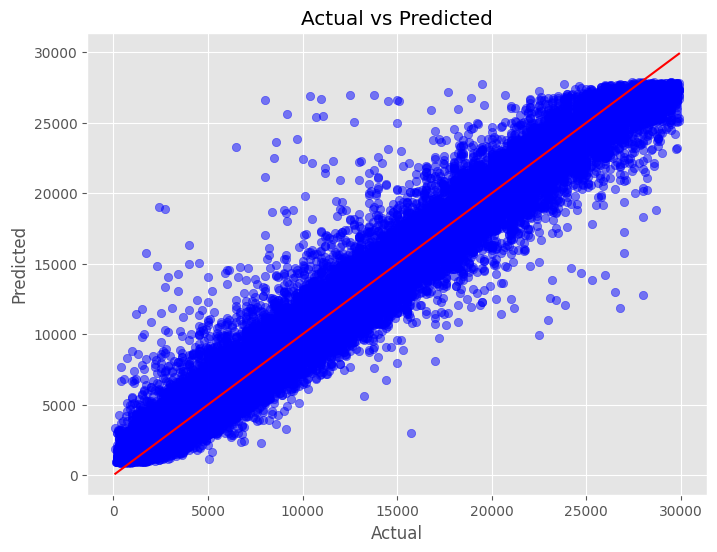

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line for reference
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

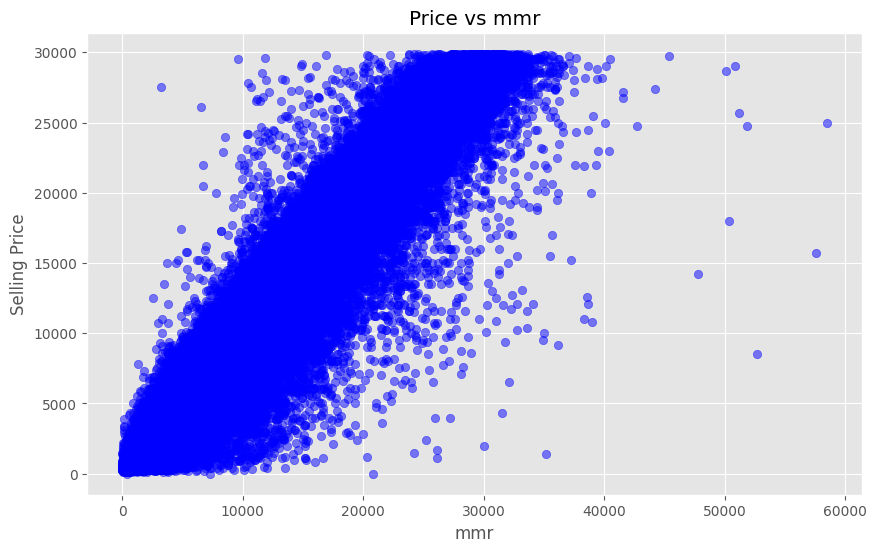

In [ ]:
# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Get the names of all features
feature_names = X.columns

# Find the index of the most important feature
most_important_feature_index = np.argmax(feature_importances)

# Get the name of the most important feature
most_important_feature_name = feature_names[most_important_feature_index]

# Plot the relationship between the most important feature and selling price
plt.figure(figsize=(10, 6))
plt.scatter(X[most_important_feature_name], y, color='blue', alpha=0.5)
plt.title(f'Price vs {most_important_feature_name}')
plt.xlabel(most_important_feature_name)
plt.ylabel('Selling Price')
plt.show()
